## Dependecies

In [31]:
import pickle
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, LSTM, Dense, Flatten, Dropout, BatchNormalization, GlobalMaxPool1D
from tensorflow.keras import optimizers
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score

## Loading needed data

In [5]:
we_train = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Customer Feedback Classification/absa/notebooks/pickled files/WE_X_train.pkl', 'rb'))
ytrain = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Customer Feedback Classification/absa/notebooks/pickled files/y_train.pkl', 'rb'))
test = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Customer Feedback Classification/absa/notebooks/pickled files/X_test.pkl', 'rb'))

## Splitting data into Necessary sets

In [6]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(we_train, ytrain, test_size=0.30, random_state=42)

# Validation Split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

## Building the Model

### Sequential

In [14]:
model = Sequential()

model.add(Embedding(input_dim=len(ytrain), output_dim=50,
                    input_length=32, trainable=True))
model.add(BatchNormalization(axis=1, momentum=0.50))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(50))
model.add(Dropout(0.3))

model.add(Dense(3, activation='softmax'))

opt = optimizers.Adam()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
n_epochs = 3
b_size = 10
model.summary()

In [ ]:
tf.keras.utils.plot_model(model)

In [15]:
train = model.fit(x_train, y_train,
                  epochs=n_epochs,
                  batch_size=b_size,
                  validation_data=(x_val, y_val))

val_loss, val_acc = model.evaluate(x_test, y_test)

print('%.2f'%(val_loss * 100),'%', 'Validation Loss')
print('%.2f'%(val_acc * 100),'%', 'Validation Accuracy')

Epoch 1/3
554/554 [==============================] - 31s 50ms/step - loss: 0.9021 - accuracy: 0.5612 - val_loss: 0.6482 - val_accuracy: 0.7498
Epoch 2/3
554/554 [==============================] - 24s 43ms/step - loss: 0.4375 - accuracy: 0.8485 - val_loss: 0.5146 - val_accuracy: 0.8239
Epoch 3/3
38/38 [==============================] - 0s 12ms/step - loss: 0.5564 - accuracy: 0.8130
55.64 % Validation Loss
81.30 % Validation Accuracy


#### Accuracy and Loss Visualization

Text(0, 0.5, 'Accuracy')

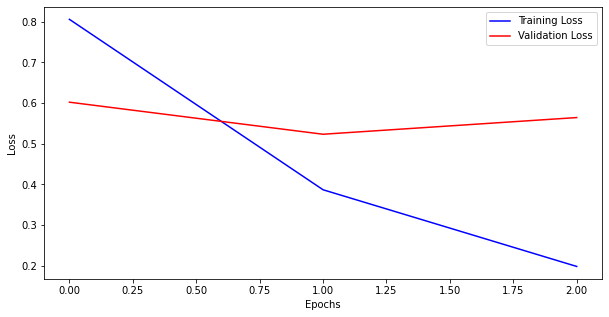

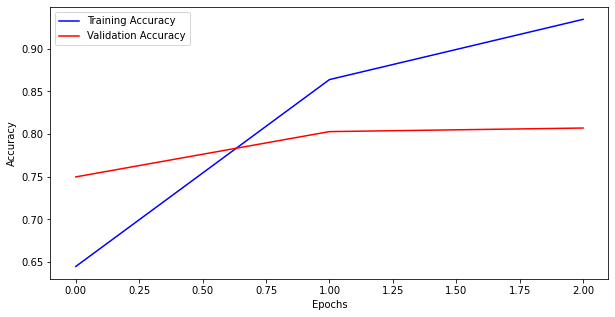

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train.history['loss'], 'blue')
plt.plot(train.history['val_loss'], 'red')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(figsize=(10, 5))
plt.plot(train.history['accuracy'], 'blue')
plt.plot(train.history['val_accuracy'], 'red')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

#### Hyper-Parameter Tuning

##### Grid-Search Regularization Params

In [24]:
values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
all_train, all_val = [], []

for param in values:
  model = Sequential()

  model.add(Embedding(input_dim=len(ytrain), output_dim=50,

                      input_length=32, trainable=True))
  model.add(BatchNormalization(momentum=0.50))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.3))

  model.add(LSTM(50))
  model.add(Dropout(0.3))

  model.add(Dense(3, activation='softmax'))

  opt = optimizers.Adam(param)
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.fit(x_train, y_train,
            epochs=3,
            batch_size=10, verbose=0,
            validation_data=(x_test, y_test),
            shuffle=True)
  model.save(f'/content/drive/MyDrive/Colab Notebooks/Customer Feedback Classification/absa/models/LSTM/Hyperparam Tuning/my_model{param}.h5')

  train_loss , train_acc = model.evaluate(x_train, y_train, verbose=0)
  val_loss , val_acc = model.evaluate(x_val, y_val, verbose=0)
  print('Param: %f; Train Accuracy: %.3f, Train loss: %.3f, Validation Accuracy: %.3f, Validation loss: %.3f' %
        (param, train_acc, train_loss, val_acc, val_loss))
  all_train.append([train_acc, train_loss])
  all_val.append([val_acc, val_loss])

Param: 0.100000; Train Accuracy: 0.320, Train loss: 1.103, Validation Accuracy: 0.332, Validation loss: 1.094
Param: 0.010000; Train Accuracy: 0.734, Train loss: 0.634, Validation Accuracy: 0.623, Validation loss: 0.844
Param: 0.001000; Train Accuracy: 0.956, Train loss: 0.157, Validation Accuracy: 0.815, Validation loss: 0.597
Param: 0.000100; Train Accuracy: 0.855, Train loss: 0.438, Validation Accuracy: 0.704, Validation loss: 0.708
Param: 0.000010; Train Accuracy: 0.425, Train loss: 1.075, Validation Accuracy: 0.425, Validation loss: 1.073
Param: 0.000001; Train Accuracy: 0.376, Train loss: 1.095, Validation Accuracy: 0.385, Validation loss: 1.097


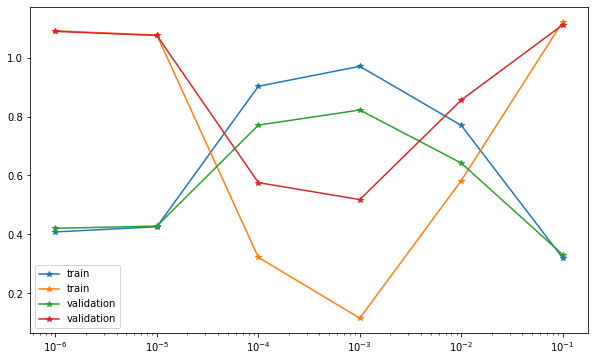

In [19]:
plt.figure(figsize=(10, 6))
plt.semilogx(values, all_train, label='train', marker='*')
plt.semilogx(values, all_val, label='validation', marker='*')
plt.legend()
plt.show()

#### Making Predictions

In [44]:
model_1e3 = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Customer Feedback Classification/absa/models/LSTM/Hyperparam Tuning/my_model0.001.h5')
model_1e4 = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Customer Feedback Classification/absa/models/LSTM/Hyperparam Tuning/my_model0.0001.h5')
model_1e5 = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Customer Feedback Classification/absa/models/LSTM/Hyperparam Tuning/my_model1e-05.h5')

pred3 = model_1e3.predict(x_val)
pred3 = pd.DataFrame(pred3)

pred4 = model_1e4.predict(x_val)
pred4 = pd.DataFrame(pred4)

pred5 = model_1e5.predict(x_val)
pred5 = pd.DataFrame(pred5)

#### Visualizing Probability Distributions for Each Predicted Class

##### Model 1e-3

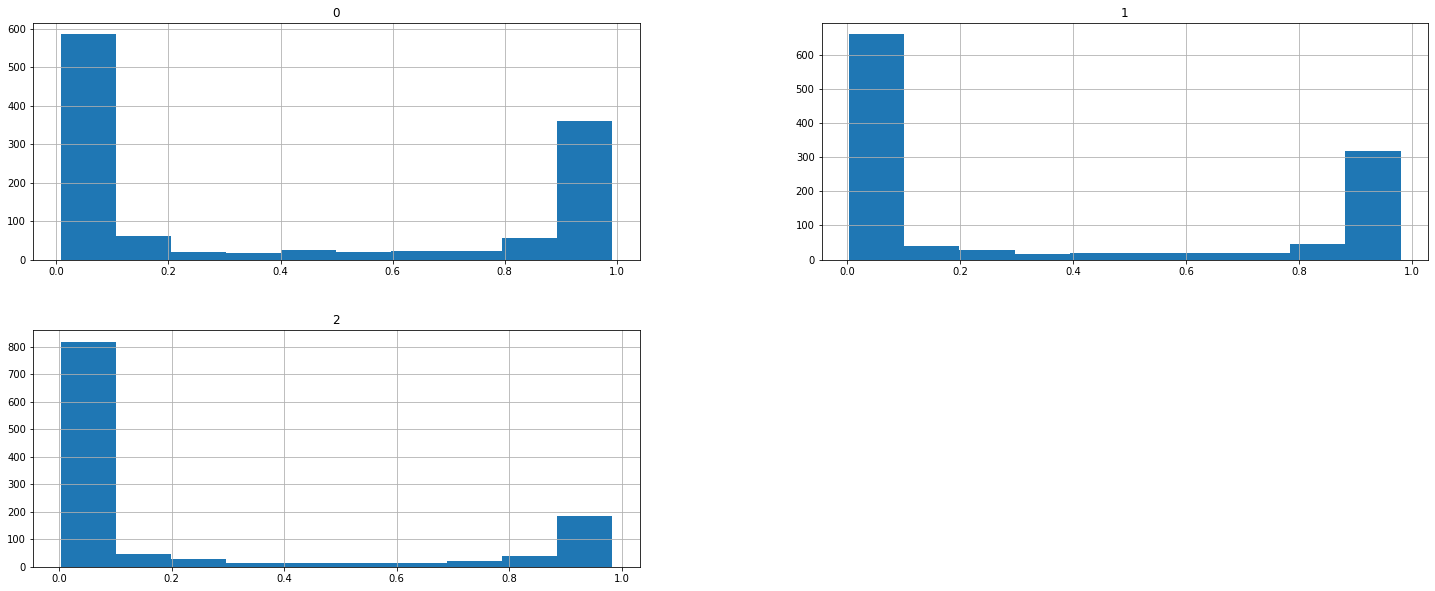

In [45]:
pred3.hist(figsize=(25, 10))
plt.show()

##### Model 1e-4

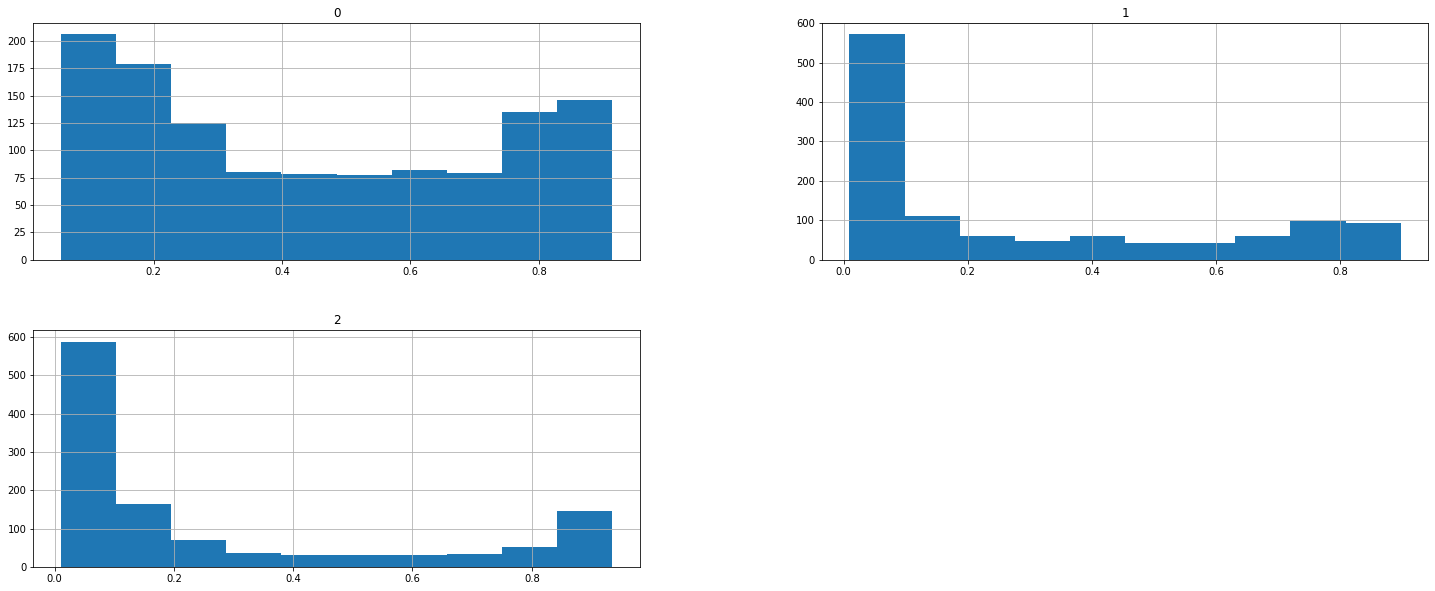

In [46]:
pred4.hist(figsize=(25, 10))
plt.show()

##### Model 1e-5

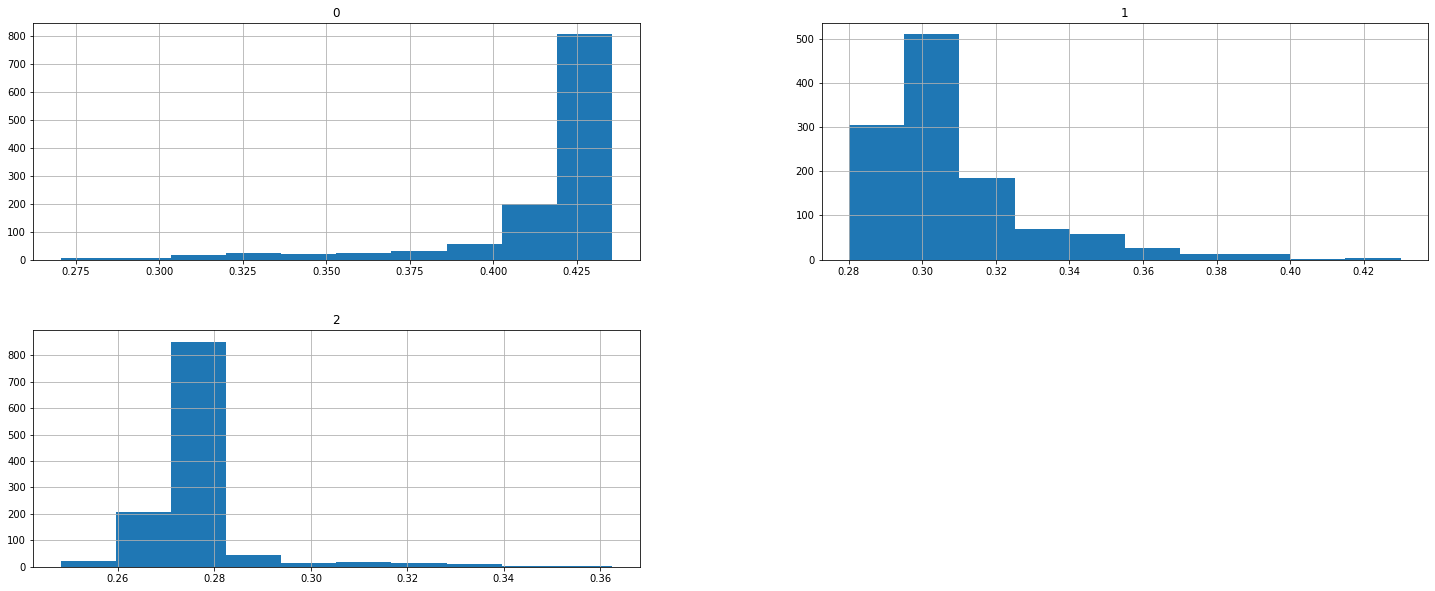

In [47]:
pred5.hist(figsize=(25, 10))
plt.show()